# Reverse Diffusion a Mathematical Intuition

This notebook explains, step by step and with small 1-D examples, the mathematics behind the DDPM reverse step:

$$ x_{t-1} = \frac{1}{\sqrt{\alpha_t}}\Big(x_t - \frac{\beta_t}{\sqrt{1-\bar\alpha_t}}\,\epsilon_t\Big) + \sigma_t z $$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def beta_schedule(T=12, b_start=1e-4, b_end=0.02):
    return np.linspace(b_start, b_end, T, dtype=np.float64)

def compute_alphas(betas):
    alphas = 1.0 - betas
    alpha_bar = np.cumprod(alphas)
    return alphas, alpha_bar

In [3]:
T = 12
betas = beta_schedule(T=T)
alphas, alpha_bar = compute_alphas(betas)

print("T =", T)
print("betas:", np.round(betas, 6))
print("alphas:", np.round(alphas, 6))
print("alpha_bar:", np.round(alpha_bar, 6))


T = 12
betas: [0.0001   0.001909 0.003718 0.005527 0.007336 0.009145 0.010955 0.012764
 0.014573 0.016382 0.018191 0.02    ]
alphas: [0.9999   0.998091 0.996282 0.994473 0.992664 0.990855 0.989045 0.987236
 0.985427 0.983618 0.981809 0.98    ]
alpha_bar: [0.9999   0.997991 0.99428  0.988785 0.981531 0.972554 0.9619   0.949623
 0.935784 0.920454 0.903711 0.885636]


With this, we have: 

* $\beta_t$: variance schedule (we use linear)
* $\alpha_t = 1 - \beta_t$
* $\bar\alpha_t = \prod_{i=1}^t \alpha_i\ $

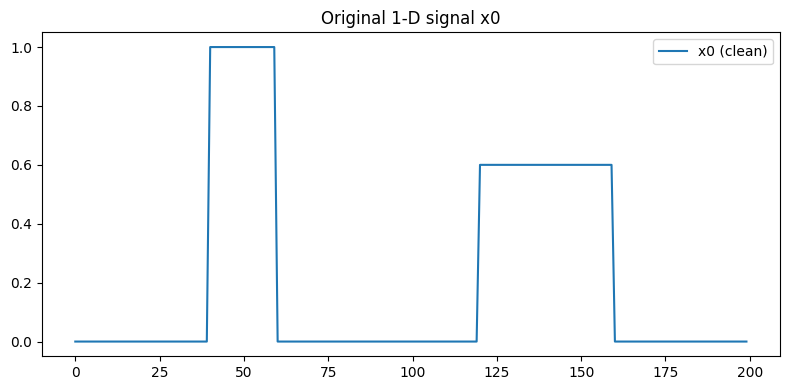

In [4]:
n = 200
x0 = np.zeros(n, dtype=np.float64)
x0[40:60] = 1.0 #first jump
x0[120:160] = 0.6 #second jump

plt.figure(figsize=(8, 4))
plt.plot(x0, label='x0 (clean)')
plt.title('Original 1-D signal x0')
plt.legend()
plt.tight_layout()
plt.show()

We create a short vector $x0$ with a clear shape so we can see how the signal is destroyed by noise. The forward formula(for the cumulative form) used here is:

$$ x_t = \sqrt{\bar\alpha_t}\,x_0 + \sqrt{1 - \bar\alpha_t}\,\epsilon,\quad \epsilon\sim\mathcal{N}(0,I) $$

We compute $x_T$ (the most noisy) and also store intermediate $x_t$ for later.


In [5]:
x0_norm = x0.copy()
xt_list = []
eps_list = []

for t in range(T):
    eps = np.random.normal(loc=0.0, scale=1.0, size=x0.shape)
    xt = np.sqrt(alpha_bar[t]) * x0_norm + np.sqrt(1.0 - alpha_bar[t]) * eps
    xt_list.append(xt)
    eps_list.append(eps)

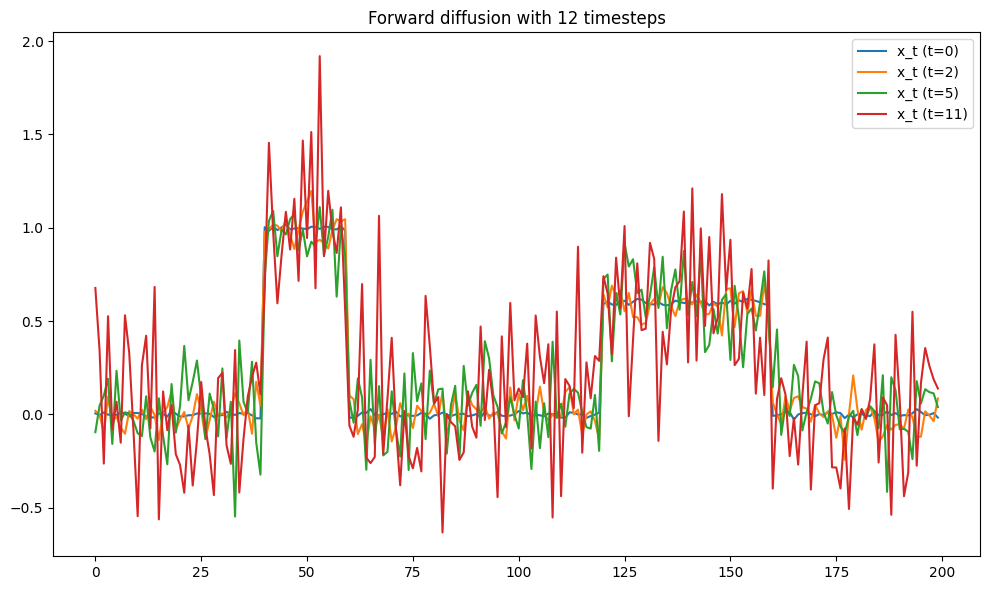

In [ ]:
plt.figure(figsize=(10, 6))

for idx in [0, 2, 5, T-1]:
    plt.plot(xt_list[idx], label=f'x_t (t={idx})')

plt.title(f'Forward diffusion with {T} timesteps')
plt.legend()
plt.tight_layout()
plt.show()

We plot $\sqrt{\bar\alpha_t}$ and $\sqrt{1-\bar\alpha_t}$ to see how signal and noise weights change with $t$.

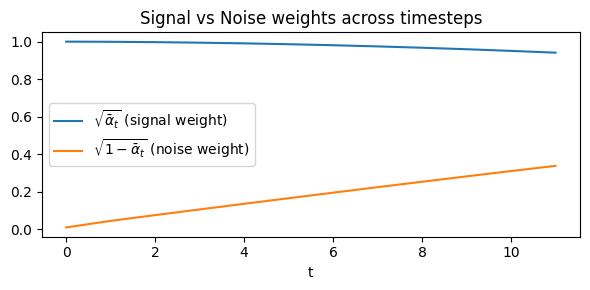

In [7]:
sqrt_ab = np.sqrt(alpha_bar)
sig_weig = r'$\sqrt{\bar\alpha_t}$ (signal weight)'

sqrt_one_minus_ab = np.sqrt(1 - alpha_bar)
noi_weig = r'$\sqrt{1-\bar\alpha_t}$ (noise weight)'

plt.figure(figsize=(6,3))
plt.plot(sqrt_ab, label = sig_weig)
plt.plot(sqrt_one_minus_ab, label= noi_weig)
plt.xlabel('t')
plt.title('Signal vs Noise weights across timesteps')
plt.legend()
plt.tight_layout()
plt.show()

## Reverse step

Reverse step used in DDPM:

$$ x_{t-1} =
\underbrace{\frac{1}{\sqrt{\alpha_t}}\left(x_t - \frac{\beta_t}{\sqrt{1-\bar\alpha_t}}\,\epsilon_t\right)}_{\text{deterministic mean}}
\;+\;
\underbrace{\sigma_t z}_{\text{stochastic term}},\quad z\sim\mathcal N(0,I) $$

We implement:
- p_sample_stochastic: includes the sigma*z term
- p_sample_deterministic: removes the sigma*z term (useful to see effect)


In [8]:
def p_sample_stochastic(xt, t, eps_t, betas, alphas, alpha_bar):
    beta_t = betas[t]
    alpha_t = alphas[t]
    ab_t = alpha_bar[t]
    mean = (xt - (beta_t / np.sqrt(1 - ab_t)) * eps_t) / np.sqrt(alpha_t)
    if t > 0:
        z = np.random.normal(size=xt.shape)
        sigma_t = np.sqrt(beta_t)
        return mean + sigma_t * z
    else:
        return mean

def p_sample_deterministic(xt, t, eps_t, betas, alphas, alpha_bar):
    #same mean, but do not add sigma*z
    beta_t = betas[t]
    alpha_t = alphas[t]
    ab_t = alpha_bar[t]
    mean = (xt - (beta_t / np.sqrt(1 - ab_t)) * eps_t) / np.sqrt(alpha_t)
    return mean


In [9]:
#from the final xt, t = T-1
xT = xt_list[-1].copy()

#stochastic reverse
x = xT.copy()
stochastic_trace = [x.copy()]
for t in reversed(range(T)):
    x = p_sample_stochastic(x, t, eps_list[t], betas, alphas, alpha_bar)
    stochastic_trace.append(x.copy())

#deterministic reverse
x = xT.copy()
deterministic_trace = [x.copy()]
for t in reversed(range(T)):
    x = p_sample_deterministic(x, t, eps_list[t], betas, alphas, alpha_bar)
    deterministic_trace.append(x.copy())

#results
x_stochastic_final = stochastic_trace[-1]
x_deterministic_final = deterministic_trace[-1]

#errors against x0
l1_stoch = np.mean(np.abs(x_stochastic_final - x0_norm))
l2_stoch = np.mean((x_stochastic_final - x0_norm)**2)

l1_det = np.mean(np.abs(x_deterministic_final - x0_norm))
l2_det = np.mean((x_deterministic_final - x0_norm)**2)

print("Final errors:")
print(f"stochastic L1={l1_stoch:.4f}, L2={l2_stoch:.4f}")
print(f"deterministic L1={l1_det:.4f}, L2={l2_det:.4f}")


Final errors:
stochastic L1=0.4100, L2=0.2536
deterministic L1=0.2824, L2=0.1177


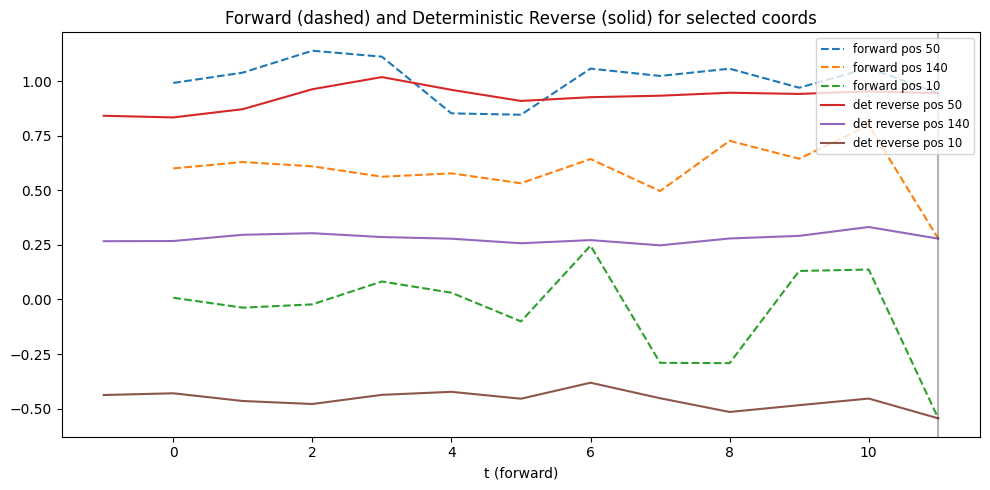

In [10]:
coords = [50, 140, 10] 

forward_vals = np.array([xt_list[t][coords] for t in range(T)])
reverse_vals_det = np.array([deterministic_trace[::-1][i][coords] for i in range(T+1)])  # t=0..T
reverse_vals_sto = np.array([stochastic_trace[::-1][i][coords] for i in range(T+1)])

plt.figure(figsize=(10,5))
for c in coords:
    #forward curve
    fwd = np.array([xt_list[t][c] for t in range(T)])
    plt.plot(np.arange(T), fwd, '--', label=f'forward pos {c}')

for c in coords:
    revd = np.array([deterministic_trace[::-1][i][c] for i in range(T+1)])
    plt.plot(np.arange(-1, T), revd, '-', label=f'det reverse pos {c}')

plt.axvline(x=T-1, color='k', alpha=0.3)
plt.title('Forward (dashed) and Deterministic Reverse (solid) for selected coords')
plt.xlabel('t (forward)')
plt.legend(loc='upper right', fontsize='small')
plt.tight_layout()
plt.show()


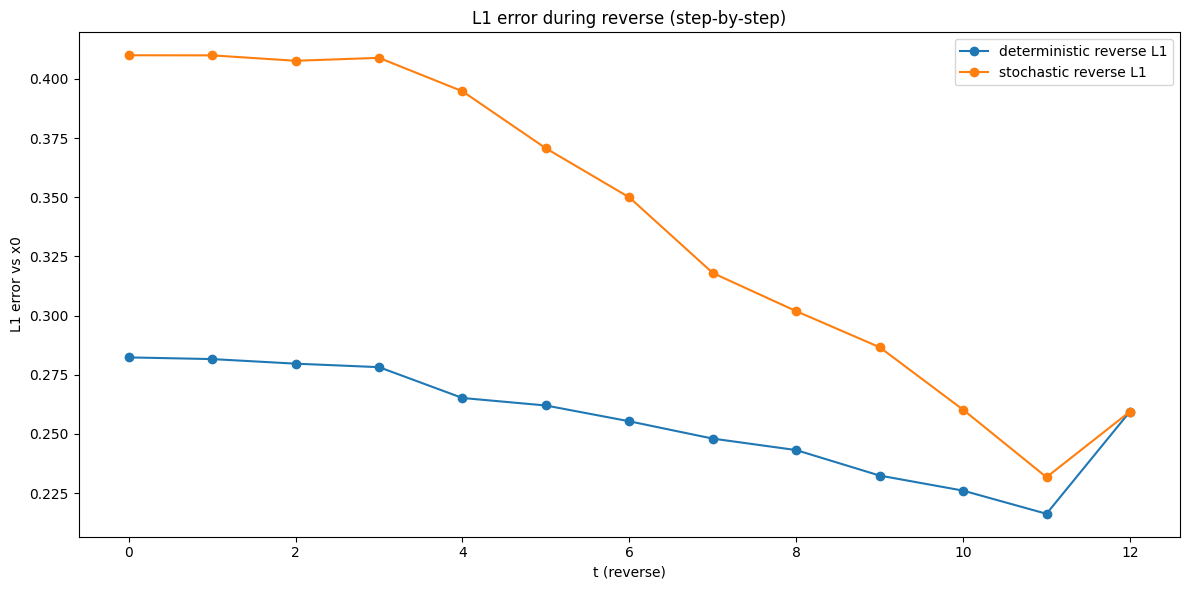

In [11]:
l1_trace_det = [np.mean(np.abs(deterministic_trace[i] - x0_norm)) for i in range(len(deterministic_trace))]
l1_trace_sto = [np.mean(np.abs(stochastic_trace[i] - x0_norm)) for i in range(len(stochastic_trace))]

plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(l1_trace_det))[::-1], l1_trace_det, '-o', label='deterministic reverse L1')
plt.plot(np.arange(len(l1_trace_sto))[::-1], l1_trace_sto, '-o', label='stochastic reverse L1')
plt.xlabel('t (reverse)')
plt.ylabel('L1 error vs x0')
plt.title('L1 error during reverse (step-by-step)')
plt.legend()
plt.tight_layout()
plt.show()


## Observations

- Signal vs noise weights: $\sqrt{\bar\alpha_t}$ decays with $t$ while $\sqrt{1-\bar\alpha_t}$ grows.
  At large $t$ the signal contribution is tiny. this is why reverse must infer structure.

- Deterministic vs stochastic reverse:
  - The deterministic variant (without sigma) is typically lower variance in reconstruction, because we remove the extra injected randomness. However, it's not "magic": 'cause the errors remain with the forward, it destroys information.

  - The stochastic reverse mimics the DDPM sampling distribution: it adds noise at each step, making exact reconstruction harder but matching the model's generative distribution.

- The $\epsilon_t$:
  - In these experiments we used a know forward $\epsilon_t$. In practice we need a model for this, it need to learn thi and if the model predicts $\epsilon_t$ well, the reverse chain will reconstruct good images.

- Not perfectly invertible: the forward operation mixes signal and independent noise, when the signal weight is extremely small, the original content is effectively lost in high dimensions.
